# Credit Risk Modeling — PD, LGD, EAD (Freddie Mac 2010–2024)

This notebook loads the engineered feature tables and trains/tunes **PD**, **LGD**, and **EAD** models:
- **PD**: Logistic Regression (with WoE), Random Forest, XGBoost (with calibration).
- **LGD**: Logit-OLS baseline (linear model on logit-transformed LGD), Random Forest Regressor, XGBoost Regressor.
- **EAD**: CCF (= EAD / OrigUPB) regressions with Random Forest and XGBoost (and a simple linear baseline).

> Notes:
> - Splits are **time-based** by origination month when available; otherwise fallback to random split.
> - We avoid leakage by using **origination-only features** (plus WoE encodings) for PD; LGD/EAD also use origination features.
> - Metrics: AUC, KS, Hosmer–Lemeshow (PD); MAE/RMSE (LGD/EAD). Calibration for PD where applicable.


In [16]:
!pip install -q xgboost
!pip install -q pyarrow fastparquet


In [3]:
import os, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Save artifacts
import joblib

# XGBoost (install if needed)
try:
    from xgboost import XGBClassifier, XGBRegressor
except Exception as e:
    print("Trying to install xgboost...")
    try:
        import sys
        from xgboost import XGBClassifier, XGBRegressor
    except Exception as _:
        raise

warnings.filterwarnings("ignore")  # keep output clean

# Paths (adjust if needed)
DATA_DIR = Path("/content/drive/MyDrive/freddie mac")  # change to your path if using Drive/Colab
FEATURES_DIR = DATA_DIR / "features"

PD_FEATURES_PATH = FEATURES_DIR / "features_pd.parquet"
LGD_EAD_PATH = FEATURES_DIR / "features_lgd_ead.parquet"
META_PATH = FEATURES_DIR / "feature_meta.json"

print("Using paths:")
print(" PD features:", PD_FEATURES_PATH)
print(" LGD/EAD:", LGD_EAD_PATH)
print(" Meta:", META_PATH)

Using paths:
 PD features: /content/drive/MyDrive/freddie mac/features/features_pd.parquet
 LGD/EAD: /content/drive/MyDrive/freddie mac/features/features_lgd_ead.parquet
 Meta: /content/drive/MyDrive/freddie mac/features/feature_meta.json


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def read_parquet_robust(path):
    return pd.read_parquet(path)


pd_df = read_parquet_robust(PD_FEATURES_PATH)
print("PD shape:", pd_df.shape)
if LGD_EAD_PATH.exists():
    lgd_df = read_parquet_robust(LGD_EAD_PATH)
    print("LGD/EAD shape:", lgd_df.shape)
else:
    lgd_df = pd.DataFrame()
    print("LGD/EAD file not found; LGD/EAD sections will be skipped.")

with open(META_PATH,'r') as f:
    meta = json.load(f)
print("Meta summary:", json.dumps(meta, indent=2)[:600], "...")

PD shape: (737500, 24)
LGD/EAD shape: (2914, 7)
Meta summary: {
  "n_loans_pd": 737500,
  "n_defaults_lifetime": 26001,
  "n_with_90dpd": 24617,
  "n_with_liquidation": 2914,
  "woe_vars": {
    "channel": {
      "iv": 0.0036837006717230295,
      "levels": 3
    },
    "occupancy_status": {
      "iv": 0.003622327538280056,
      "levels": 3
    },
    "property_type": {
      "iv": 0.006768844398866535,
      "levels": 5
    },
    "loan_purpose": {
      "iv": 0.006423098408643666,
      "levels": 3
    },
    "property_state": {
      "iv": 0.06974253194195361,
      "levels": 54
    }
  },
  "has_lgd_ead": true,
  "lgd_ead_rows": 2914
} ...


In [5]:
print("Columns sample (PD):", pd_df.columns.tolist()[:30])

# Counts from data vs meta (if available)
n_loans = pd_df.shape[0]
n_defaults = int(pd_df.get('pd_default_flag', pd.Series([0]*len(pd_df))).fillna(0).sum())
n_90 = int(pd_df.get('__first_90dpd_month', pd.Series([np.nan]*len(pd_df))).notna().sum())
n_liq = int(pd_df.get('__first_liq_month', pd.Series([np.nan]*len(pd_df))).notna().sum())

print(f"Loans: {n_loans:,} | lifetime defaults: {n_defaults:,} | 90+ DPD: {n_90:,} | liquidations: {n_liq:,}")

# Basic target rate
if 'pd_default_flag' in pd_df.columns:
    print("PD default rate:", pd_df['pd_default_flag'].mean())

Columns sample (PD): ['loan_sequence_number', 'original_upb', 'credit_score', 'original_debt_to_income_dti_ratio', 'original_loan_to_value_ltv', 'original_combined_loan_to_value_cltv', 'original_interest_rate', 'channel', 'occupancy_status', 'property_type', 'loan_purpose', 'property_state', 'first_payment_date', 'maturity_date', 'pd_default_flag', '__first_90dpd_month', '__first_liq_month', 'dti_bin', 'ltv_bin', 'channel_woe', 'occupancy_status_woe', 'property_type_woe', 'loan_purpose_woe', 'property_state_woe']
Loans: 737,500 | lifetime defaults: 26,001 | 90+ DPD: 24,617 | liquidations: 2,914
PD default rate: 0.035255593220338985


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def ks_stat(y_true, y_score):
    # Computes Kolmogorov–Smirnov (distance between CDFs of positives/negatives)
    df = pd.DataFrame({'y': y_true, 'score': y_score})
    df = df.sort_values('score', ascending=True)
    df['cum_bad'] = (df['y'] == 1).cumsum() / max(1, (df['y'] == 1).sum())
    df['cum_good'] = (df['y'] == 0).cumsum() / max(1, (df['y'] == 0).sum())
    ks = (df['cum_bad'] - df['cum_good']).abs().max()
    return float(ks)

def hosmer_lemeshow(y_true, y_prob, n_bins=10):
    # Group by predicted probability deciles and compute chi-square
    df = pd.DataFrame({'y': y_true, 'p': y_prob})
    df['bin'] = pd.qcut(df['p'], n_bins, duplicates='drop')
    g = df.groupby('bin').agg(obs=('y','sum'), total=('y','size'), p_hat=('p','mean')).reset_index(drop=True)
    g['exp'] = g['total'] * g['p_hat']
    g['exp_non'] = g['total'] - g['exp']
    g['obs_non'] = g['total'] - g['obs']
    # Add small eps to avoid /0
    eps = 1e-9
    hl_stat = (((g['obs'] - g['exp'])**2) / (g['exp']+eps) + ((g['obs_non'] - g['exp_non'])**2) / (g['exp_non']+eps)).sum()
    df_ = max(1, (g.shape[0]-2))
    p_value = 1 - chi2.cdf(hl_stat, df_)
    return float(hl_stat), float(p_value), g[['total','obs','exp','p_hat']]

def print_pd_metrics(y_true, proba, name):
    auc = roc_auc_score(y_true, proba)
    ks = ks_stat(y_true, proba)
    hl_stat, hl_p, _ = hosmer_lemeshow(y_true, proba, n_bins=10)
    bs = brier_score_loss(y_true, proba)
    print(f"[{name}] AUC={auc:.4f} | KS={ks:.4f} | HL stat={hl_stat:.2f} (p={hl_p:.3f}) | Brier={bs:.5f}")

In [8]:
# Define PD features (origination + WoE)
# Start with numeric origination fields (if present)
numeric_cols = [c for c in ['credit_score','original_debt_to_income_dti_ratio','original_dti','dti',
                            'original_loan_to_value_ltv','ltv','original_cltv','cltv',
                            'original_upb','orig_upb','original_interest_rate','interest_rate']
                if c in pd_df.columns]

# WoE columns (already numeric)
woe_cols = [c for c in pd_df.columns if c.endswith('_woe')]

# Drop target and date columns from features
drop_cols = set(['pd_default_flag','pd_12m_default_flag','__first_90dpd_month','__first_liq_month','__first_default_month',
                 'loan_sequence_number','loan_id','first_payment_date','maturity_date','orig_month'])

X_cols = sorted(list(set(numeric_cols + woe_cols) - drop_cols))
print("Using", len(X_cols), "PD features.")
X_cols[:20]

Using 10 PD features.


['channel_woe',
 'credit_score',
 'loan_purpose_woe',
 'occupancy_status_woe',
 'original_debt_to_income_dti_ratio',
 'original_interest_rate',
 'original_loan_to_value_ltv',
 'original_upb',
 'property_state_woe',
 'property_type_woe']

In [9]:
# Train/valid/test split (time-based when possible)
def make_splits(df, date_col_candidates=('orig_month','first_payment_date','__first_default_month'),
                train_end='2018-12-01', valid_end='2021-12-01'):
    # Choose a date column
    date_col = None
    for c in date_col_candidates:
        if c in df.columns:
            date_col = c
            break
    if date_col:
        d = pd.to_datetime(df[date_col], errors='coerce')
        train_mask = d <= pd.to_datetime(train_end)
        valid_mask = (d > pd.to_datetime(train_end)) & (d <= pd.to_datetime(valid_end))
        test_mask  = d > pd.to_datetime(valid_end)
        return train_mask.fillna(False), valid_mask.fillna(False), test_mask.fillna(False), date_col
    # Fallback: random split
    rng = np.random.RandomState(42)
    r = rng.rand(len(df))
    return (r < 0.6), ((r >= 0.6) & (r < 0.8)), (r >= 0.8), None

y = pd_df['pd_default_flag'].astype(int)
X = pd_df[X_cols].copy()

# Simple imputing for numeric columns
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

train_mask, valid_mask, test_mask, split_col = make_splits(pd_df)
print("Split by:", split_col or "random")
print("Train/Valid/Test sizes:", X[train_mask].shape, X[valid_mask].shape, X[test_mask].shape)

Split by: first_payment_date
Train/Valid/Test sizes: (442184, 10) (149866, 10) (145450, 10)


In [10]:
#  Logistic Regression (with scaling, class_weight balanced)
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=True, with_std=True)),
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, X_cols),
], remainder='drop')

logit = LogisticRegression(max_iter=200, solver='saga', class_weight='balanced', n_jobs=-1)

pipe_logit = Pipeline([
    ('prep', preprocess),
    ('clf', logit),
])

param_grid_logit = {
    'clf__C': [0.1, 0.3, 1.0, 3.0],
    'clf__penalty': ['l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_logit = GridSearchCV(pipe_logit, param_grid_logit, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
gs_logit.fit(X[train_mask], y[train_mask])

print("Best Logit params:", gs_logit.best_params_, "AUC (cv):", gs_logit.best_score_)

# Evaluate
proba_valid = gs_logit.predict_proba(X[valid_mask])[:,1]
print_pd_metrics(y[valid_mask], proba_valid, "Logit (valid)")

proba_test = gs_logit.predict_proba(X[test_mask])[:,1]
print_pd_metrics(y[test_mask], proba_test, "Logit (test)")

joblib.dump(gs_logit.best_estimator_, 'pd_model_logit.joblib'); print("Saved pd_model_logit.joblib")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logit params: {'clf__C': 3.0, 'clf__penalty': 'l2'} AUC (cv): 0.7482649543770542
[Logit (valid)] AUC=0.7635 | KS=0.3943 | HL stat=100889.99 (p=0.000) | Brier=0.17785
[Logit (test)] AUC=0.7022 | KS=0.3036 | HL stat=249522.98 (p=0.000) | Brier=0.33429
Saved pd_model_logit.joblib


In [11]:
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

# Calibrate on the validation split (isotonic is flexible, better for large data)
logit_best = gs_logit.best_estimator_
cal_logit = CalibratedClassifierCV(logit_best, cv='prefit', method='isotonic')
cal_logit.fit(X[valid_mask], y[valid_mask])

# Re-evaluate metrics
proba_valid_cal = cal_logit.predict_proba(X[valid_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_cal, "Logit + Isotonic (valid)")
proba_test_cal = cal_logit.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[test_mask], proba_test_cal, "Logit + Isotonic (test)")

# Compare against a naive baseline Brier (constant = prevalence)
p_valid = y[valid_mask].mean()
p_test  = y[test_mask].mean()
brier_valid_baseline = np.mean((y[valid_mask] - p_valid)**2)
brier_test_baseline  = np.mean((y[test_mask]  - p_test )**2)
print(f"Baseline Brier (valid) ≈ p(1-p) = {p_valid*(1-p_valid):.5f} (calc={brier_valid_baseline:.5f})")
print(f"Baseline Brier (test ) ≈ p(1-p) = {p_test *(1-p_test ):.5f} (calc={brier_test_baseline:.5f})")

import joblib
joblib.dump(cal_logit, "pd_model_logit_calibrated.joblib")
print("Saved pd_model_logit_calibrated.joblib")

# Are we over/under-predicting on TEST?
pred_mean_test = proba_test_cal.mean()
actual_test = y[test_mask].mean()
print(f"Mean PD (test): predicted={pred_mean_test:.4%} | actual={actual_test:.4%}")



[Logit + Isotonic (valid)] AUC=0.7647 | KS=0.3958 | HL stat=0.00 (p=1.000) | Brier=0.03102
[Logit + Isotonic (test)] AUC=0.7022 | KS=0.3042 | HL stat=7018.16 (p=0.000) | Brier=0.02122
Baseline Brier (valid) ≈ p(1-p) = 0.03225 (calc=0.03225)
Baseline Brier (test ) ≈ p(1-p) = 0.01586 (calc=0.01586)
Saved pd_model_logit_calibrated.joblib
Mean PD (test): predicted=7.0644% | actual=1.6116%


Calibration table (VALID) — before:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14987,0.109326,0.003737,1638.466841,56,0.105589
1,14987,0.176592,0.005471,2646.583545,82,0.171121
2,14986,0.229286,0.008741,3436.072720,131,0.220544
3,14987,0.280307,0.011543,4200.958126,173,0.268763
4,14986,0.332549,0.019552,4983.580700,293,0.312998
5,14987,0.388499,0.026356,5822.436536,395,0.362143
6,14986,0.450180,0.033164,6746.398090,497,0.417016
7,14987,0.519856,0.045773,7791.084685,686,0.474083
8,14986,0.604285,0.063059,9055.820475,945,0.541227
9,14987,0.734610,0.116234,11009.598639,1742,0.618376


Calibration table (VALID) — after:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,28562,0.004446,0.004446,127.0,127,0.000000e+00
1,1584,0.007576,0.007576,12.0,12,0.000000e+00
2,17265,0.008746,0.008746,151.0,151,0.000000e+00
3,15114,0.012836,0.012836,194.0,194,0.000000e+00
4,13268,0.019822,0.019822,263.0,263,0.000000e+00
5,19861,0.027189,0.027189,540.0,540,0.000000e+00
6,15242,0.038184,0.038184,582.0,582,6.938894e-18
7,17359,0.053402,0.053402,927.0,927,0.000000e+00
8,7353,0.070311,0.070311,517.0,517,0.000000e+00
9,14258,0.118320,0.118320,1687.0,1687,0.000000e+00


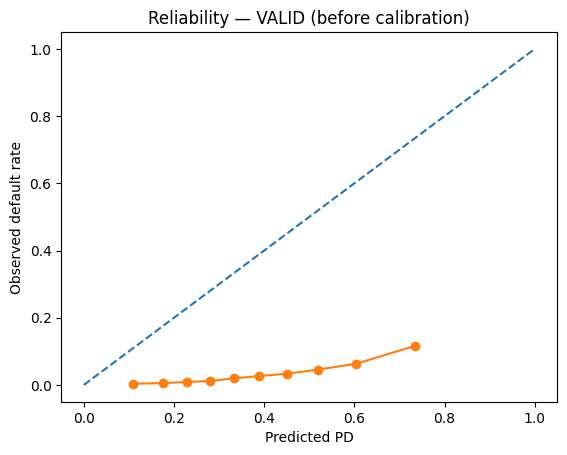

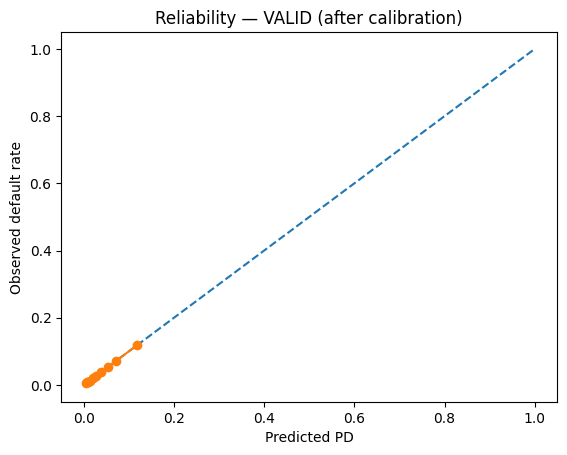

Calibration table (TEST) — before:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14545,0.193912,0.003369,2820.444127,49,0.190543
1,14545,0.318461,0.004331,4632.012531,63,0.314129
2,14545,0.400746,0.006325,5828.856108,92,0.394421
3,14545,0.469151,0.008388,6823.794560,122,0.460763
4,14545,0.529965,0.011207,7708.343892,163,0.518759
5,14545,0.588686,0.015332,8562.443292,223,0.573355
6,14545,0.647159,0.017669,9412.926451,257,0.629490
7,14545,0.706944,0.024957,10282.498979,363,0.681987
8,14545,0.771484,0.029082,11221.234149,423,0.742402
9,14545,0.856630,0.040495,12459.685796,589,0.816135


Calibration table (TEST) — after:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,15815,0.007155,0.003351,113.155980,53,0.003804
1,13311,0.017561,0.004432,233.757850,59,0.013129
2,15706,0.027388,0.006622,430.163703,104,0.020767
3,16244,0.038498,0.008311,625.354594,135,0.030187
4,23866,0.053912,0.013366,1286.654034,319,0.040545
5,7402,0.064973,0.017158,480.926626,127,0.047815
6,14475,0.085889,0.020035,1243.242018,290,0.065854
7,10301,0.105667,0.025726,1088.471578,265,0.079941
8,15456,0.133513,0.029697,2063.575378,459,0.103816
9,12874,0.210493,0.041401,2709.882370,533,0.169091


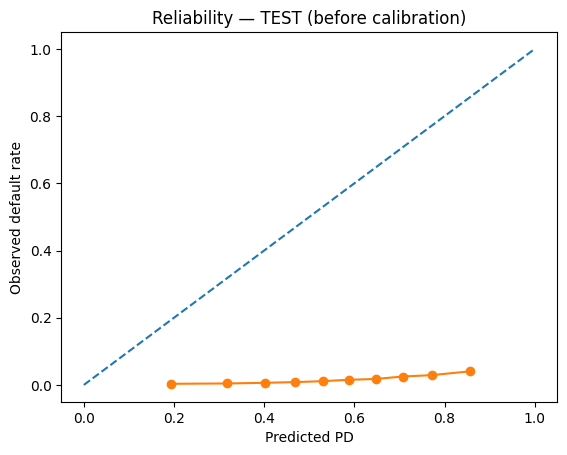

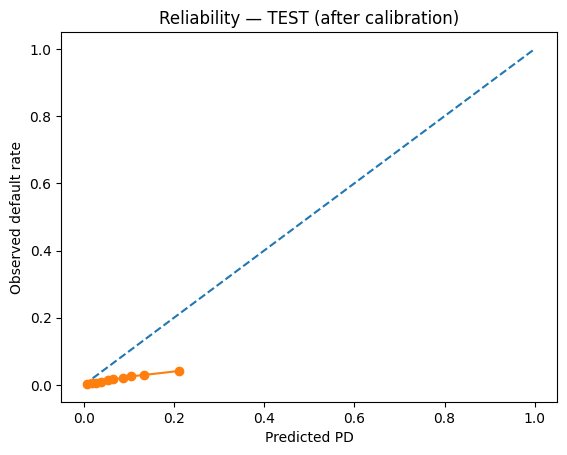

Chosen threshold (maximize KS on VALID) = 0.035479 | KS at thr = 0.3943

[VALID (calibrated)] @ thr=0.035479
TP=3,611  FP=47,506  TN=97,360  FN=1,389
Recall=0.722 | Specificity=0.672 | Precision=0.071 | NPV=0.986 | Predicted-positive rate=34.108%

[TEST  (calibrated)] @ thr=0.035479
TP=2,102  FP=95,573  TN=47,533  FN=242
Recall=0.897 | Specificity=0.332 | Precision=0.022 | NPV=0.995 | Predicted-positive rate=67.154%


In [12]:
# === RELIABILITY TABLES + PLOTS, THEN CONFUSION MATRIX (run after calibration) ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, precision_score

# --- Reliability helpers ---
def calibration_table(y_true, p_hat, n_bins=10):
    df = pd.DataFrame({'y': y_true.astype(int), 'p': p_hat}).sort_values('p')
    df['bin'] = pd.qcut(df['p'], n_bins, duplicates='drop')  # equal-count bins (deciles)
    g = df.groupby('bin').agg(
        n=('y','size'),
        pred_mean=('p','mean'),
        obs_rate=('y','mean'),
        exp_defaults=('p','sum'),
        obs_defaults=('y','sum'),
    ).reset_index(drop=True)
    g['gap'] = g['pred_mean'] - g['obs_rate']
    return g

def plot_reliability(tbl, title):
    plt.figure()
    plt.plot([0,1],[0,1],'--')
    plt.plot(tbl['pred_mean'], tbl['obs_rate'], marker='o')
    plt.xlabel('Predicted PD'); plt.ylabel('Observed default rate'); plt.title(title)
    plt.show()

# --- Reliability tables/plots: VALID ---
tbl_valid_before = calibration_table(y[valid_mask], proba_valid, n_bins=10)
tbl_valid_after  = calibration_table(y[valid_mask], proba_valid_cal, n_bins=10)
print("Calibration table (VALID) — before:"); display(tbl_valid_before)
print("Calibration table (VALID) — after:");  display(tbl_valid_after)
plot_reliability(tbl_valid_before, "Reliability — VALID (before calibration)")
plot_reliability(tbl_valid_after,  "Reliability — VALID (after calibration)")

# --- Reliability tables/plots: TEST ---
tbl_test_before = calibration_table(y[test_mask], proba_test, n_bins=10)
tbl_test_after  = calibration_table(y[test_mask], proba_test_cal, n_bins=10)
print("Calibration table (TEST) — before:"); display(tbl_test_before)
print("Calibration table (TEST) — after:");  display(tbl_test_after)
plot_reliability(tbl_test_before, "Reliability — TEST (before calibration)")
plot_reliability(tbl_test_after,  "Reliability — TEST (after calibration)")

# --- Choose threshold by maximizing KS on VALID (using calibrated probs) ---
def best_threshold_by_ks(y_true, proba):
    fpr, tpr, thr = roc_curve(y_true, proba)
    ks = tpr - fpr
    i = np.argmax(ks)
    return float(thr[i]), float(ks[i])

thr_val, ks_at_thr = best_threshold_by_ks(y[valid_mask], proba_valid_cal)
print(f"Chosen threshold (maximize KS on VALID) = {thr_val:.6f} | KS at thr = {ks_at_thr:.4f}")

# --- Confusion matrices @ chosen threshold ---
def print_confusion(name, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn + 1e-12)       # recall / sensitivity
    tnr = tn / (tn + fp + 1e-12)       # specificity
    ppv = precision_score(y_true, y_pred, zero_division=0)  # precision
    npv = tn / (tn + fn + 1e-12)
    pos_rate = (proba >= thr).mean()
    print(f"\n[{name}] @ thr={thr:.6f}")
    print(f"TP={tp:,}  FP={fp:,}  TN={tn:,}  FN={fn:,}")
    print(f"Recall={tpr:.3f} | Specificity={tnr:.3f} | Precision={ppv:.3f} | NPV={npv:.3f} | Predicted-positive rate={pos_rate:.3%}")

print_confusion("VALID (calibrated)", y[valid_mask], proba_valid_cal, thr_val)
print_confusion("TEST  (calibrated)", y[test_mask],  proba_test_cal,  thr_val)


In [13]:
# Random Forest Classifier + calibration

rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),         # RF can't take NaNs
    ('rf', RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

# Fit
rf_pipe.fit(X[train_mask], y[train_mask])

# Pre-calibration metrics
proba_valid_rf = rf_pipe.predict_proba(X[valid_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_rf, "RF (valid)")
proba_test_rf  = rf_pipe.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[test_mask],  proba_test_rf,  "RF (test)")

# Calibrate on VALID (Platt/sigmoid tends to generalize better than isotonic for RF)
rf_cal = CalibratedClassifierCV(rf_pipe, cv='prefit', method='sigmoid')
rf_cal.fit(X[valid_mask], y[valid_mask])

proba_valid_rf_cal = rf_cal.predict_proba(X[valid_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_rf_cal, "RF+Platt (valid)")
proba_test_rf_cal  = rf_cal.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[test_mask],  proba_test_rf_cal,  "RF+Platt (test)")

# Save both (raw + calibrated)
joblib.dump(rf_pipe, 'pd_model_rf.joblib');       print("Saved pd_model_rf.joblib")
joblib.dump(rf_cal,  'pd_model_rf_cal.joblib');   print("Saved pd_model_rf_cal.joblib")


[RF (valid)] AUC=0.7581 | KS=0.3927 | HL stat=44407.90 (p=0.000) | Brier=0.09255
[RF (test)] AUC=0.7204 | KS=0.3463 | HL stat=103969.62 (p=0.000) | Brier=0.16825
[RF+Platt (valid)] AUC=0.7581 | KS=0.3927 | HL stat=101.89 (p=0.000) | Brier=0.03105
[RF+Platt (test)] AUC=0.7204 | KS=0.3463 | HL stat=5827.38 (p=0.000) | Brier=0.02063
Saved pd_model_rf.joblib
Saved pd_model_rf_cal.joblib


Calibration table (VALID) — before:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14987,0.051096,0.005805,765.777078,87,0.045291
1,14987,0.089952,0.007807,1348.107774,117,0.082145
2,14986,0.118791,0.010476,1780.205886,157,0.108315
3,14987,0.148246,0.011543,2221.767386,173,0.136703
4,14986,0.182717,0.017216,2738.189978,258,0.165500
5,14987,0.224452,0.024621,3363.863855,369,0.199831
6,14986,0.276358,0.030562,4141.506103,458,0.245796
7,14987,0.339261,0.044639,5084.504434,669,0.294622
8,14986,0.425982,0.061924,6383.770002,928,0.364058
9,14987,0.593733,0.119036,8898.272358,1784,0.474696


Calibration table (VALID) — after:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14987,0.009178,0.005805,137.545437,87,0.003373
1,14987,0.011079,0.007807,166.040700,117,0.003272
2,14986,0.012756,0.010476,191.155936,157,0.002279
3,14987,0.014731,0.011543,220.778208,173,0.003188
4,14986,0.017431,0.017216,261.217973,258,0.000215
5,14987,0.021362,0.024621,320.148141,369,-0.003260
6,14986,0.027475,0.030562,411.739692,458,-0.003087
7,14987,0.037195,0.044639,557.439988,669,-0.007444
8,14986,0.056324,0.061924,844.069201,928,-0.005601
9,14987,0.126100,0.119036,1889.865112,1784,0.007064


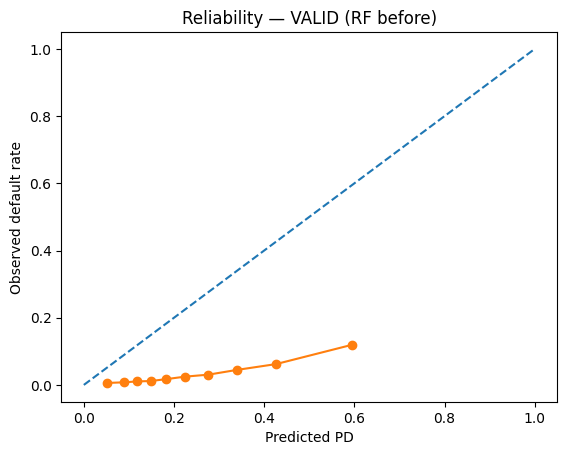

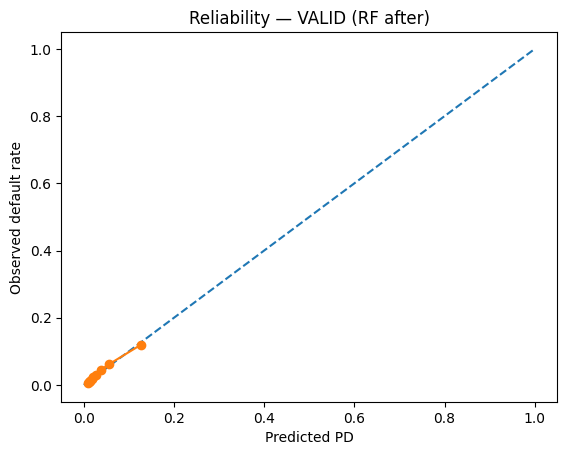

Calibration table (TEST) — before:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14545,0.096054,0.003300,1397.099015,48,0.092753
1,14545,0.146681,0.004056,2133.479177,59,0.142625
2,14545,0.188583,0.004538,2742.945392,66,0.184046
3,14545,0.234565,0.006188,3411.746553,90,0.228377
4,14545,0.287337,0.009832,4179.314826,143,0.277505
5,14545,0.349806,0.014300,5087.928811,208,0.335506
6,14545,0.424094,0.020144,6168.453698,293,0.403950
7,14545,0.510280,0.023857,7422.023438,347,0.486423
8,14545,0.608762,0.033482,8854.442245,487,0.575280
9,14545,0.737252,0.041458,10723.328464,603,0.695794


Calibration table (TEST) — after:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14545,0.011488,0.003300,167.099347,48,0.008188
1,14545,0.014628,0.004056,212.766458,59,0.010572
2,14545,0.017945,0.004538,261.005599,66,0.013407
3,14545,0.022437,0.006188,326.345293,90,0.016249
4,14545,0.028964,0.009832,421.281803,143,0.019132
5,14545,0.039097,0.014300,568.658659,208,0.024796
6,14545,0.055588,0.020144,808.531115,293,0.035444
7,14545,0.082838,0.023857,1204.882122,347,0.058981
8,14545,0.128285,0.033482,1865.910377,487,0.094803
9,14545,0.219671,0.041458,3195.110755,603,0.178213


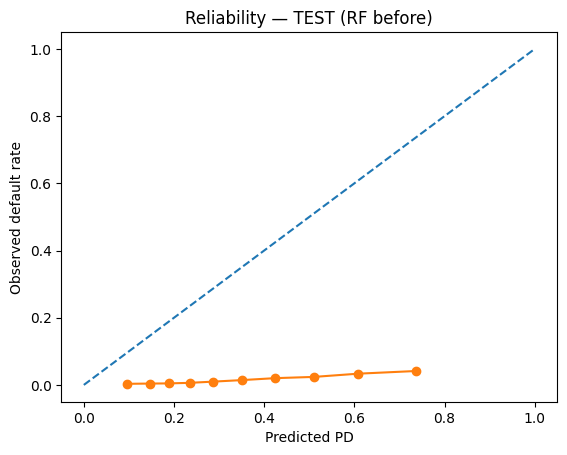

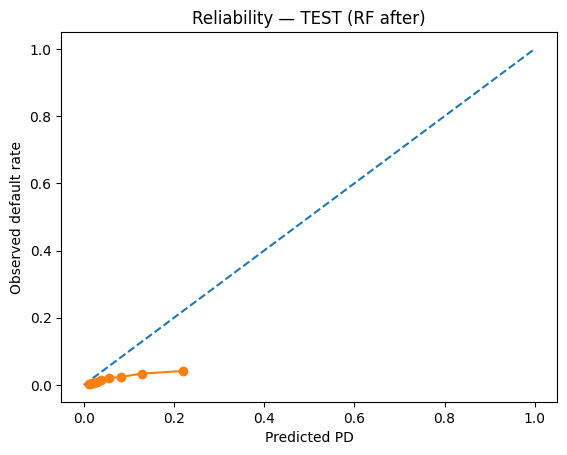

RF threshold (KS-opt on VALID) = 0.029356 | KS=0.3927

[VALID (RF+Platt)] @ thr=0.029356
TP=3,522  FP=45,153  TN=99,713  FN=1,478
Recall=0.704 | Specificity=0.688 | Precision=0.072 | NPV=0.985 | Predicted-positive rate=32.479%

[TEST  (RF+Platt)] @ thr=0.029356
TP=2,015  FP=77,023  TN=66,083  FN=329
Recall=0.860 | Specificity=0.462 | Precision=0.025 | NPV=0.995 | Predicted-positive rate=54.340%


In [14]:

# VALID: before/after calibration
tbl_valid_before = calibration_table(y[valid_mask], proba_valid_rf, n_bins=10)
tbl_valid_after  = calibration_table(y[valid_mask], proba_valid_rf_cal, n_bins=10)
print("Calibration table (VALID) — before:"); display(tbl_valid_before)
print("Calibration table (VALID) — after:");  display(tbl_valid_after)
plot_reliability(tbl_valid_before, "Reliability — VALID (RF before)")
plot_reliability(tbl_valid_after,  "Reliability — VALID (RF after)")

# TEST: before/after calibration
tbl_test_before = calibration_table(y[test_mask], proba_test_rf, n_bins=10)
tbl_test_after  = calibration_table(y[test_mask], proba_test_rf_cal, n_bins=10)
print("Calibration table (TEST) — before:"); display(tbl_test_before)
print("Calibration table (TEST) — after:");  display(tbl_test_after)
plot_reliability(tbl_test_before, "Reliability — TEST (RF before)")
plot_reliability(tbl_test_after,  "Reliability — TEST (RF after)")

# KS-optimal threshold for RF (use calibrated VALID probs)
thr_val_rf, ks_at_thr_rf = best_threshold_by_ks(y[valid_mask], proba_valid_rf_cal)
print(f"RF threshold (KS-opt on VALID) = {thr_val_rf:.6f} | KS={ks_at_thr_rf:.4f}")

# Confusion matrices at that threshold
print_confusion("VALID (RF+Platt)", y[valid_mask], proba_valid_rf_cal, thr_val_rf)
print_confusion("TEST  (RF+Platt)", y[test_mask],  proba_test_rf_cal,  thr_val_rf)


In [18]:
#  XGBoost Classifier  + calibration(s)

# Handle imbalance (same as before)
pos = int(y[train_mask].sum())
neg = int(y[train_mask].shape[0] - pos)
spw = max(1.0, neg / max(1, pos))

xgb = XGBClassifier(
    n_estimators=600,              # fixed trees; you can try 400–800
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric='auc',            # ranking-focused metric
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=spw
)

# Fit on TRAIN
xgb.fit(X[train_mask], y[train_mask])

# Pre-calibration (just to see baseline)
proba_valid_xgb = xgb.predict_proba(X[valid_mask])[:, 1]
proba_test_xgb  = xgb.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_xgb, "XGB (valid, raw)")
print_pd_metrics(y[test_mask],  proba_test_xgb,  "XGB (test,  raw)")

# ---- Calibrate on VALID ----
# 1) Platt (sigmoid) - often generalizes better OOT when base rates drift
cal_platt = CalibratedClassifierCV(xgb, cv='prefit', method='sigmoid')
cal_platt.fit(X[valid_mask], y[valid_mask])

proba_valid_sig = cal_platt.predict_proba(X[valid_mask])[:, 1]
proba_test_sig  = cal_platt.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_sig, "XGB + Platt (valid)")
print_pd_metrics(y[test_mask],  proba_test_sig,  "XGB + Platt (test)")

# 2) Isotonic - very flexible, fits VALID tightly
cal_iso = CalibratedClassifierCV(xgb, cv='prefit', method='isotonic')
cal_iso.fit(X[valid_mask], y[valid_mask])

proba_valid_iso = cal_iso.predict_proba(X[valid_mask])[:, 1]
proba_test_iso  = cal_iso.predict_proba(X[test_mask])[:, 1]
print_pd_metrics(y[valid_mask], proba_valid_iso, "XGB + Isotonic (valid)")
print_pd_metrics(y[test_mask],  proba_test_iso,  "XGB + Isotonic (test)")

# Compare mean PDs (sanity) and Brier on TEST to choose one
mean_valid_act = y[valid_mask].mean()
mean_test_act  = y[test_mask].mean()
print("Mean PD (VALID): platt={:.4%} | iso={:.4%} | actual={:.4%}".format(
    proba_valid_sig.mean(), proba_valid_iso.mean(), mean_valid_act))
print("Mean PD (TEST):  platt={:.4%} | iso={:.4%} | actual={:.4%}".format(
    proba_test_sig.mean(),  proba_test_iso.mean(),  mean_test_act))

brier_test_platt = brier_score_loss(y[test_mask], proba_test_sig)
brier_test_iso   = brier_score_loss(y[test_mask], proba_test_iso)
print(f"Brier (TEST): Platt={brier_test_platt:.5f} | Isotonic={brier_test_iso:.5f}")

# Choose the calibrator with lower TEST Brier
chosen_name, chosen_cal, proba_valid_cal, proba_test_cal = (
    ("platt", cal_platt, proba_valid_sig, proba_test_sig)
    if brier_test_platt <= brier_test_iso
    else ("isotonic", cal_iso, proba_valid_iso, proba_test_iso)
)
print("Chosen XGB calibrator:", chosen_name.upper())


joblib.dump(cal_iso,  'pd_model_xgb_isotonic.joblib'); print("Saved pd_model_xgb_isotonic.joblib")
joblib.dump(cal_platt,  'pd_model_xgb_platt.joblib');    print("Saved pd_model_xgb_platt.joblib")



[XGB (valid, raw)] AUC=0.7680 | KS=0.4078 | HL stat=87049.24 (p=0.000) | Brier=0.15444
[XGB (test,  raw)] AUC=0.7192 | KS=0.3430 | HL stat=200660.40 (p=0.000) | Brier=0.25945
[XGB + Platt (valid)] AUC=0.7680 | KS=0.4078 | HL stat=36.99 (p=0.000) | Brier=0.03097
[XGB + Platt (test)] AUC=0.7192 | KS=0.3430 | HL stat=5222.61 (p=0.000) | Brier=0.01973
[XGB + Isotonic (valid)] AUC=0.7693 | KS=0.4089 | HL stat=0.00 (p=1.000) | Brier=0.03093
[XGB + Isotonic (test)] AUC=0.7189 | KS=0.3429 | HL stat=5385.93 (p=0.000) | Brier=0.02039
Mean PD (VALID): platt=3.3356% | iso=3.3363% | actual=3.3363%
Mean PD (TEST):  platt=5.8799% | iso=5.9490% | actual=1.6116%
Brier (TEST): Platt=0.01973 | Isotonic=0.02039
Chosen XGB calibrator: PLATT
Saved pd_model_xgb_isotonic.joblib
Saved pd_model_xgb_platt.joblib


Calibration table (VALID) — raw:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14987,0.048683,0.004404,729.609192,66,0.044279
1,14987,0.106561,0.006205,1597.034790,93,0.100356
2,14986,0.158209,0.008208,2370.919678,123,0.150001
3,14987,0.212029,0.014412,3177.673096,216,0.197616
4,14986,0.270619,0.014480,4055.491211,217,0.256138
5,14987,0.334441,0.023687,5012.274414,355,0.310754
6,14986,0.406120,0.031429,6086.118164,471,0.374691
7,14987,0.488906,0.046574,7327.237305,698,0.442333
8,14986,0.589869,0.065528,8839.779297,982,0.524341
9,14987,0.738560,0.118703,11068.796875,1779,0.619857


Calibration table (VALID) — isotonic:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,19733,0.004206,0.004206,83.000039,83,1.999491e-09
1,13507,0.007107,0.007107,95.999999,96,-7.736314e-11
2,13061,0.008728,0.008728,114.000489,114,3.743220e-08
3,27459,0.014422,0.014422,396.000003,396,1.219989e-10
4,2169,0.016590,0.016598,35.983409,36,-7.649010e-06
5,14278,0.024513,0.024513,349.991074,350,-6.251664e-07
6,17803,0.032524,0.032523,579.026401,579,1.482977e-06
7,15785,0.049477,0.049477,781.000049,781,3.088321e-09
8,13158,0.071592,0.071591,942.002644,942,2.009460e-07
9,12913,0.125687,0.125687,1622.999980,1623,-1.517465e-09


Calibration table (VALID) — Platt:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14987,0.005933,0.004404,88.923784,66,0.001530
1,14987,0.007688,0.006205,115.216896,93,0.001482
2,14986,0.009701,0.008208,145.378933,123,0.001493
3,14987,0.012358,0.014412,185.206644,216,-0.002055
4,14986,0.016072,0.014480,240.859665,217,0.001592
5,14987,0.021372,0.023687,320.305420,355,-0.002315
6,14986,0.029384,0.031429,440.347486,471,-0.002045
7,14987,0.042301,0.046574,633.967466,698,-0.004273
8,14986,0.065491,0.065528,981.448602,982,-0.000037
9,14987,0.123256,0.118703,1847.232031,1779,0.004553


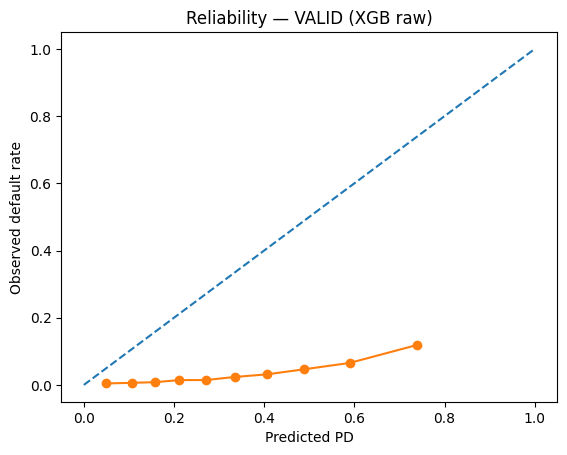

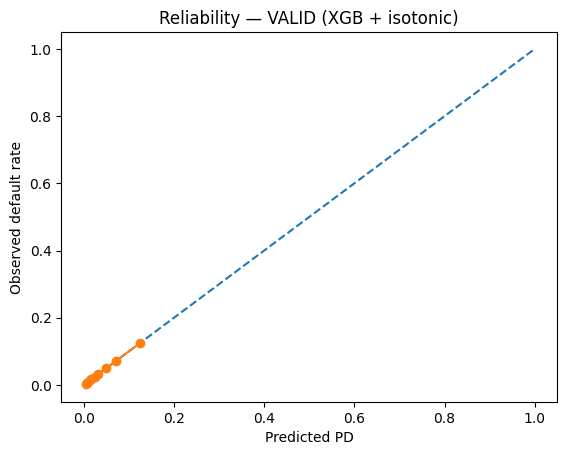

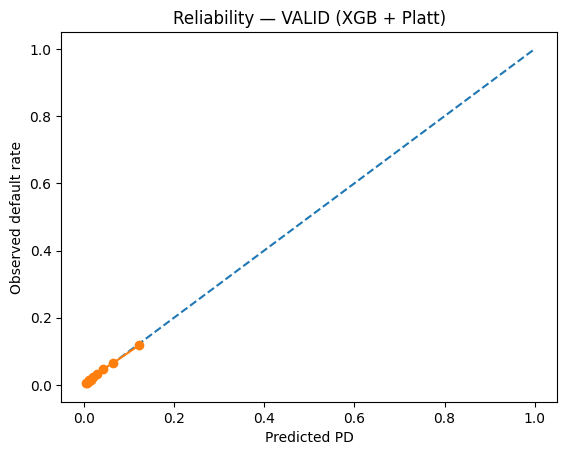

Calibration table (TEST) — raw:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14545,0.053612,0.001925,779.793640,28,0.051687
1,14545,0.131528,0.003506,1913.075317,51,0.128022
2,14545,0.211233,0.005294,3072.389893,77,0.205939
3,14545,0.297929,0.006394,4333.383789,93,0.291535
4,14545,0.390938,0.010588,5686.194824,154,0.380350
5,14545,0.485020,0.015263,7054.616699,222,0.469757
6,14545,0.579306,0.021588,8426.006836,314,0.557718
7,14545,0.668850,0.024820,9728.421875,361,0.644030
8,14545,0.756983,0.031145,11010.313477,453,0.725838
9,14545,0.856927,0.040633,12464.001953,591,0.816294


Calibration table (TEST) — isotonic:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,15316,0.004087,0.002155,62.589864,33,0.001932
1,14604,0.007376,0.003218,107.724851,47,0.004158
2,20846,0.013981,0.005709,291.448401,119,0.008272
3,11425,0.023504,0.006827,268.535184,78,0.016677
4,11434,0.031307,0.012769,357.959599,146,0.018538
5,18213,0.047865,0.015758,871.768204,287,0.032107
6,13114,0.069649,0.023791,913.377106,312,0.045858
7,12073,0.089079,0.024683,1075.445927,298,0.064395
8,14663,0.126802,0.031440,1859.299695,461,0.095362
9,13762,0.206710,0.040910,2844.736509,563,0.165800


Calibration table (TEST) — Platt:


,n,pred_mean,obs_rate,exp_defaults,obs_defaults,gap
0,14545,0.006077,0.001925,88.386367,28,0.004152
1,14545,0.008627,0.003506,125.481321,51,0.005121
2,14545,0.012352,0.005294,179.656104,77,0.007058
3,14545,0.018219,0.006394,264.992699,93,0.011825
4,14545,0.027546,0.010588,400.656000,154,0.016958
5,14545,0.041618,0.015263,605.328901,222,0.026355
6,14545,0.062419,0.021588,907.887026,314,0.040831
7,14545,0.090839,0.024820,1321.249170,361,0.066019
8,14545,0.129678,0.031145,1886.171010,453,0.098534
9,14545,0.190619,0.040633,2772.550792,591,0.149986


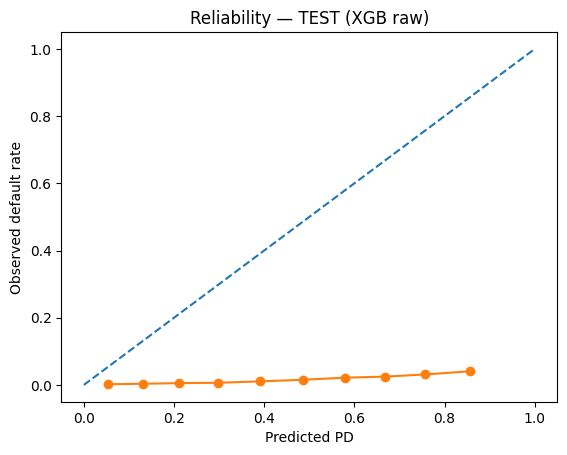

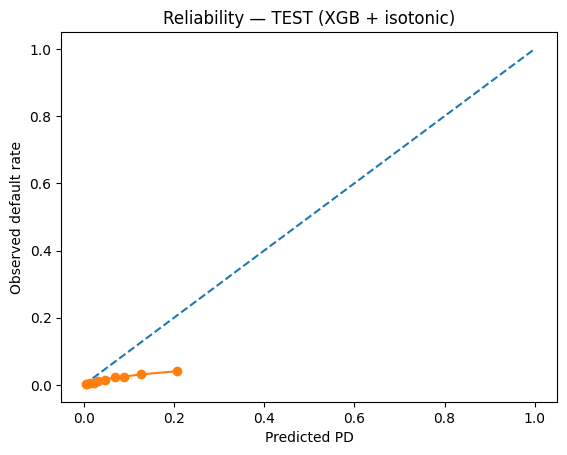

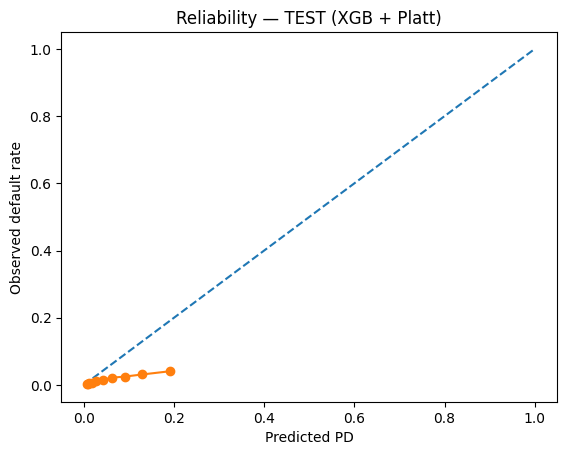

XGB threshold (VALID, isotonic) = 0.035730 | KS=0.4078
XGB threshold (VALID, Platt)    = 0.032771 | KS=0.4078

[VALID (XGB+isotonic)] @ thr=0.035730
TP=3,554  FP=43,890  TN=100,976  FN=1,446
Recall=0.711 | Specificity=0.697 | Precision=0.075 | NPV=0.986 | Predicted-positive rate=31.658%

[TEST  (XGB+isotonic)] @ thr=0.035730
TP=1,954  FP=71,730  TN=71,376  FN=390
Recall=0.834 | Specificity=0.499 | Precision=0.027 | NPV=0.995 | Predicted-positive rate=50.659%

[VALID (XGB+Platt)] @ thr=0.032771
TP=3,554  FP=43,890  TN=100,976  FN=1,446
Recall=0.711 | Specificity=0.697 | Precision=0.075 | NPV=0.986 | Predicted-positive rate=31.658%

[TEST  (XGB+Platt)] @ thr=0.032771
TP=1,954  FP=71,730  TN=71,376  FN=390
Recall=0.834 | Specificity=0.499 | Precision=0.027 | NPV=0.995 | Predicted-positive rate=50.659%


In [19]:
# === XGB reliability & confusion matrices

# --- VALID: before/after (isotonic & Platt) ---
tbl_valid_before    = calibration_table(y[valid_mask], proba_valid_xgb, n_bins=10)
tbl_valid_iso_after = calibration_table(y[valid_mask], proba_valid_iso,     n_bins=10)
tbl_valid_sig_after = calibration_table(y[valid_mask], proba_valid_sig,     n_bins=10)

print("Calibration table (VALID) — raw:");     display(tbl_valid_before)
print("Calibration table (VALID) — isotonic:"); display(tbl_valid_iso_after)
print("Calibration table (VALID) — Platt:");    display(tbl_valid_sig_after)

plot_reliability(tbl_valid_before,    "Reliability — VALID (XGB raw)")
plot_reliability(tbl_valid_iso_after, "Reliability — VALID (XGB + isotonic)")
plot_reliability(tbl_valid_sig_after, "Reliability — VALID (XGB + Platt)")

# --- TEST: before/after (isotonic & Platt) ---
tbl_test_before    = calibration_table(y[test_mask], proba_test_xgb, n_bins=10)
tbl_test_iso_after = calibration_table(y[test_mask], proba_test_iso,     n_bins=10)
tbl_test_sig_after = calibration_table(y[test_mask], proba_test_sig,     n_bins=10)

print("Calibration table (TEST) — raw:");     display(tbl_test_before)
print("Calibration table (TEST) — isotonic:"); display(tbl_test_iso_after)
print("Calibration table (TEST) — Platt:");    display(tbl_test_sig_after)

plot_reliability(tbl_test_before,    "Reliability — TEST (XGB raw)")
plot_reliability(tbl_test_iso_after, "Reliability — TEST (XGB + isotonic)")
plot_reliability(tbl_test_sig_after, "Reliability — TEST (XGB + Platt)")

# --- KS-optimal thresholds on VALID (use calibrated probs) ---
thr_xgb_iso,  ks_iso  = best_threshold_by_ks(y[valid_mask], proba_valid_iso)
thr_xgb_plat, ks_plat = best_threshold_by_ks(y[valid_mask], proba_valid_sig)
print(f"XGB threshold (VALID, isotonic) = {thr_xgb_iso:.6f} | KS={ks_iso:.4f}")
print(f"XGB threshold (VALID, Platt)    = {thr_xgb_plat:.6f} | KS={ks_plat:.4f}")

# --- Confusion matrices at those thresholds ---
print_confusion("VALID (XGB+isotonic)", y[valid_mask], proba_valid_iso, thr_xgb_iso)
print_confusion("TEST  (XGB+isotonic)", y[test_mask],  proba_test_iso,  thr_xgb_iso)

print_confusion("VALID (XGB+Platt)",    y[valid_mask], proba_valid_sig, thr_xgb_plat)
print_confusion("TEST  (XGB+Platt)",    y[test_mask],  proba_test_sig,  thr_xgb_plat)


In [20]:
import shutil

MODELS_DIR = DATA_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

for fn in [
    "pd_model_logit.joblib",
    "pd_model_logit_calibrated.joblib",
    "pd_model_rf.joblib",
    "pd_model_rf_cal.joblib",
    "pd_model_xgb_isotonic.joblib",
    "pd_model_xgb_platt.joblib",
]:
    p = Path(fn)
    if p.exists():
        shutil.copy(p, MODELS_DIR / p.name)

## LGD Modeling (on liquidated loans only)

- Target: `LGD` in (0,1); we clamp to avoid exact 0/1 for the logit transform.
- Features: same origination features used for PD (no leakage) merged onto the defaulted subset.
- Models:
  - **Logit-OLS baseline**: \( 	ext{logit}(LGD) \) ~ linear terms (Ridge).
  - **RandomForestRegressor**
  - **XGBRegressor**
- Metrics: MAE / RMSE (on original LGD scale).


In [33]:
#  LGD Modeling (liquidations only)

def rmse(y_true, y_pred):
    # works on all sklearn versions
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def print_reg_metrics(y_true, y_pred, name):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    r  = rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:.4f} | RMSE={r:.4f} | R2={r2:.4f}")


def lgd_to_logit(y):
    y2 = np.clip(y, 1e-4, 1-1e-4)
    return np.log(y2/(1-y2))

def logit_to_lgd(z):
    s = 1/(1+np.exp(-z))
    return np.clip(s, 0.0, 1.0)

if lgd_df.shape[0] == 0:
    print("No LGD/EAD data available; skipping LGD section.")
else:
    #Merge origination features into LGD table
    key_loan = 'loan_sequence_number' if 'loan_sequence_number' in pd_df.columns else 'loan_id'
    cols_needed = [key_loan] + [c for c in X_cols]  # reuse PD feature list (origination + WoE)
    t = lgd_df.merge(pd_df[cols_needed], on=key_loan, how='left')

    # Target & features
    t['LGD'] = pd.to_numeric(t['LGD'], errors='coerce')
    y_lgd = t['LGD'].clip(0.0005, 0.9995)  # clamp to (0,1) open interval
    X_lgd = t[X_cols].copy()
    for c in X_lgd.columns:
        X_lgd[c] = pd.to_numeric(X_lgd[c], errors='coerce')

    # Reuse the PD time masks by joining them to t
    pd_mask_df = pd_df[[key_loan]].copy()
    pd_mask_df['train_mask'] = train_mask.values
    pd_mask_df['valid_mask'] = valid_mask.values
    pd_mask_df['test_mask']  = test_mask.values
    t = t.merge(pd_mask_df, on=key_loan, how='left')

    # Keep rows with a valid LGD target
    valid_target = y_lgd.notna() & np.isfinite(y_lgd)

    # Final split indices (intersect with valid_target to avoid NaN leakage)
    idx_train = (t['train_mask'] == True) & valid_target
    idx_valid = (t['valid_mask'] == True) & valid_target
    idx_test  = (t['test_mask']  == True) & valid_target

    print("LGD rows (train/valid/test):",
          int(idx_train.sum()), int(idx_valid.sum()), int(idx_test.sum()))

    # 1) Logit-OLS (Ridge)
    # Impute + scale features; transform target via logit, inverse at prediction time
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    Xtr = num_pipe.fit_transform(X_lgd[idx_train])
    Xva = num_pipe.transform(X_lgd[idx_valid])
    Xte = num_pipe.transform(X_lgd[idx_test])

    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(Xtr, lgd_to_logit(y_lgd[idx_train].values))

    pred_valid = logit_to_lgd(ridge.predict(Xva))
    pred_test  = logit_to_lgd(ridge.predict(Xte))
    print_reg_metrics(y_lgd[idx_valid].values, pred_valid, "LGD Logit-OLS (valid)")
    print_reg_metrics(y_lgd[idx_test].values,  pred_test,  "LGD Logit-OLS (test)")

    # 2) RandomForest Regressor
    # sklearn RF cannot handle NaNs ⇒ use an imputer pipeline
    rf_lgd = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=25,
            n_jobs=-1,
            random_state=42
        ))
    ])
    rf_lgd.fit(X_lgd[idx_train], y_lgd[idx_train])
    pred_valid = np.clip(rf_lgd.predict(X_lgd[idx_valid]), 0, 1)
    pred_test  = np.clip(rf_lgd.predict(X_lgd[idx_test]),  0, 1)
    print_reg_metrics(y_lgd[idx_valid].values, pred_valid, "LGD RF (valid)")
    print_reg_metrics(y_lgd[idx_test].values,  pred_test,  "LGD RF (test)")

    # 3) XGB Regressor
    # XGB can handle NaNs, but we’ll impute for consistency with RF/logit
    xgb_lgd = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('xgb', XGBRegressor(
            n_estimators=600,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            tree_method='hist',
            n_jobs=-1,
            random_state=42
        ))
    ])
    xgb_lgd.fit(X_lgd[idx_train], y_lgd[idx_train])
    pred_valid = np.clip(xgb_lgd.predict(X_lgd[idx_valid]), 0, 1)
    pred_test  = np.clip(xgb_lgd.predict(X_lgd[idx_test]),  0, 1)
    print_reg_metrics(y_lgd[idx_valid].values, pred_valid, "LGD XGB (valid)")
    print_reg_metrics(y_lgd[idx_test].values,  pred_test,  "LGD XGB (test)")



    # Save artifacts (under DATA_DIR/models)
    joblib.dump({'ridge': ridge, 'num_pipe': num_pipe}, MODELS_DIR / 'lgd_model_logit_ols.joblib'); print("Saved", MODELS_DIR / 'lgd_model_logit_ols.joblib')
    joblib.dump(rf_lgd,                               MODELS_DIR / 'lgd_model_rf.joblib');        print("Saved", MODELS_DIR / 'lgd_model_rf.joblib')
    joblib.dump(xgb_lgd,                              MODELS_DIR / 'lgd_model_xgb.joblib');       print("Saved", MODELS_DIR / 'lgd_model_xgb.joblib')


    #  LGD: post-hoc calibration on VALID, evaluate on TEST

    # Recreate per-model predictions
    pred_valid_ridge = logit_to_lgd(ridge.predict(Xva))
    pred_test_ridge  = logit_to_lgd(ridge.predict(Xte))

    # RF / XGB use their own imputers inside the pipelines on raw X_lgd
    pred_valid_rf = np.clip(rf_lgd.predict(X_lgd[idx_valid]), 0, 1)
    pred_test_rf  = np.clip(rf_lgd.predict(X_lgd[idx_test]),  0, 1)

    pred_valid_xgb = np.clip(xgb_lgd.predict(X_lgd[idx_valid]), 0, 1)
    pred_test_xgb  = np.clip(xgb_lgd.predict(X_lgd[idx_test]),  0, 1)

    def calibrate_and_eval(name, p_valid, p_test):
        iso = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds='clip')
        iso.fit(p_valid, y_lgd[idx_valid].values)          # fit mapping on VALID
        pv_cal = iso.transform(p_valid)
        pt_cal = iso.transform(p_test)                      # apply to TEST
        print_reg_metrics(y_lgd[idx_valid].values, pv_cal, f"LGD {name} + iso-cal (valid)")
        print_reg_metrics(y_lgd[idx_test].values,  pt_cal, f"LGD {name} + iso-cal (test)")
        return iso, pv_cal, pt_cal

    iso_ridge, pv_ridge_cal, pt_ridge_cal = calibrate_and_eval('Ridge', pred_valid_ridge, pred_test_ridge)
    iso_rf,    pv_rf_cal,    pt_rf_cal    = calibrate_and_eval('RF',    pred_valid_rf,    pred_test_rf)
    iso_xgb,   pv_xgb_cal,   pt_xgb_cal   = calibrate_and_eval('XGB',   pred_valid_xgb,   pred_test_xgb)

    #  pick the best by VALID RMSE after calibration
    def _rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
    valid_rmse_cal = {
        'ridge': _rmse(y_lgd[idx_valid].values, pv_ridge_cal),
        'rf':    _rmse(y_lgd[idx_valid].values, pv_rf_cal),
        'xgb':   _rmse(y_lgd[idx_valid].values, pv_xgb_cal),
    }
    best_cal = min(valid_rmse_cal, key=valid_rmse_cal.get)
    print("Best VALID RMSE after calibration:", best_cal, "→", valid_rmse_cal[best_cal])

    joblib.dump(iso_ridge, MODELS_DIR / 'lgd_calibrator_ridge_orig_only.joblib'); print("Saved", MODELS_DIR / 'lgd_calibrator_ridge_orig_only.joblib')
    joblib.dump(iso_rf,    MODELS_DIR / 'lgd_calibrator_rf_orig_only.joblib');    print("Saved", MODELS_DIR / 'lgd_calibrator_rf_orig_only.joblib')
    joblib.dump(iso_xgb,   MODELS_DIR / 'lgd_calibrator_xgb_orig_only.joblib');   print("Saved", MODELS_DIR / 'lgd_calibrator_xgb_orig_only.joblib')



LGD rows (train/valid/test): 2035 373 506
[LGD Logit-OLS (valid)] MAE=0.2097 | RMSE=0.3814 | R2=-3.2030
[LGD Logit-OLS (test)] MAE=0.5314 | RMSE=0.6603 | R2=-59.3397
[LGD RF (valid)] MAE=0.2986 | RMSE=0.3574 | R2=-2.6902
[LGD RF (test)] MAE=0.3307 | RMSE=0.3586 | R2=-16.8009
[LGD XGB (valid)] MAE=0.2648 | RMSE=0.3674 | R2=-2.9007
[LGD XGB (test)] MAE=0.2815 | RMSE=0.3541 | R2=-16.3504
Saved /content/drive/MyDrive/freddie mac/models/lgd_model_logit_ols.joblib
Saved /content/drive/MyDrive/freddie mac/models/lgd_model_rf.joblib
Saved /content/drive/MyDrive/freddie mac/models/lgd_model_xgb.joblib
[LGD Ridge + iso-cal (valid)] MAE=0.0689 | RMSE=0.1841 | R2=0.0206
[LGD Ridge + iso-cal (test)] MAE=0.0704 | RMSE=0.1093 | R2=-0.6528
[LGD RF + iso-cal (valid)] MAE=0.0683 | RMSE=0.1832 | R2=0.0298
[LGD RF + iso-cal (test)] MAE=0.0507 | RMSE=0.0957 | R2=-0.2683
[LGD XGB + iso-cal (valid)] MAE=0.0695 | RMSE=0.1849 | R2=0.0124
[LGD XGB + iso-cal (test)] MAE=0.0478 | RMSE=0.0930 | R2=-0.1976
Best VAL

## EAD Modeling (via Credit Conversion Factor, CCF)

- Define **CCF = EAD_at_default / OrigUPB**.
- Fit regressions for CCF, then reconstruct \( EAD = CCF *OrigUPB \).
- Models: Linear baseline (Ridge), RandomForestRegressor, XGBRegressor.


In [36]:
# EAD Modeling via CCF (origination-only features), with calibration

#  RMSE that works on all sklearn versions
def _rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# 1) Build CCF table (only origination features from X_cols)
if lgd_df.shape[0] == 0:
    print("No LGD/EAD data available; skipping EAD.")
else:
    key_loan_pd = 'loan_sequence_number' if 'loan_sequence_number' in pd_df.columns else 'loan_id'
    key_loan_lgd = 'loan_sequence_number' if 'loan_sequence_number' in lgd_df.columns else ('loan_id' if 'loan_id' in lgd_df.columns else None)
    if key_loan_lgd is None:
        raise KeyError("lgd_df has neither 'loan_sequence_number' nor 'loan_id'")

    # Find original UPB column in pd_df
    orig_upb_col = None
    for c in ['original_upb', 'orig_upb']:
        if c in pd_df.columns:
            orig_upb_col = c
            break
    assert orig_upb_col is not None, "Missing original UPB column in pd_df."

    # Keep only X_cols that actually exist
    X_cols_ead = [c for c in X_cols if c in pd_df.columns and c != orig_upb_col]


    cols_needed = [key_loan_pd, orig_upb_col] + X_cols_ead
    # Rename orig_upb to a unique name BEFORE the merge to avoid duplicate columns
    right = pd_df[cols_needed].rename(columns={key_loan_pd: key_loan_lgd, orig_upb_col: 'orig_upb_for_ccf'})
    ead_tbl = lgd_df[[key_loan_lgd, 'EAD_at_default']].merge(right, on=key_loan_lgd, how='left')

    # Numeric coercions
    ead_tbl['orig_upb_for_ccf'] = pd.to_numeric(ead_tbl['orig_upb_for_ccf'], errors='coerce')
    ead_tbl['EAD_at_default']   = pd.to_numeric(ead_tbl['EAD_at_default'], errors='coerce')


    # Define target CCF and clamp to reasonable range
    valid_upb = ead_tbl['orig_upb_for_ccf'] > 0
    ead_tbl['CCF'] = np.where(valid_upb, ead_tbl['EAD_at_default'] / ead_tbl['orig_upb_for_ccf'], np.nan)
    ead_tbl['CCF'] = ead_tbl['CCF'].clip(lower=0.0, upper=2.0)

    # Feature matrix
    X_ead = ead_tbl[X_cols_ead].copy()
    for c in X_ead.columns:
        X_ead[c] = pd.to_numeric(X_ead[c], errors='coerce')
    y_ccf = ead_tbl['CCF']

    #  2) Reuse PD masks by mapping (more robust than merge)
    train_map = pd.Series(train_mask.astype(bool).values, index=pd_df[key_loan_pd]).to_dict()
    valid_map = pd.Series(valid_mask.astype(bool).values, index=pd_df[key_loan_pd]).to_dict()
    test_map  = pd.Series(test_mask.astype(bool).values,  index=pd_df[key_loan_pd]).to_dict()

    ead_tbl['train_mask'] = ead_tbl[key_loan_lgd].map(train_map).fillna(False).astype(bool)
    ead_tbl['valid_mask'] = ead_tbl[key_loan_lgd].map(valid_map).fillna(False).astype(bool)
    ead_tbl['test_mask']  = ead_tbl[key_loan_lgd].map(test_map ).fillna(False).astype(bool)

    # Keep rows with valid target
    valid_target = y_ccf.notna() & np.isfinite(y_ccf)
    idx_train = ead_tbl['train_mask'] & valid_target
    idx_valid = ead_tbl['valid_mask'] & valid_target
    idx_test  = ead_tbl['test_mask']  & valid_target

    print("EAD/CCF rows (train/valid/test):", int(idx_train.sum()), int(idx_valid.sum()), int(idx_test.sum()))

    # 3) Baseline: constant-mean CCF (and EAD) for context
    mu_ccf_train = float(y_ccf[idx_train].mean())
    def _print_ead_metrics(y_true_ccf, y_pred_ccf, upb, name):
        y_true_ead = y_true_ccf * upb
        y_pred_ead = y_pred_ccf * upb
        mae = float(np.mean(np.abs(y_true_ead - y_pred_ead)))
        rmse = _rmse(y_true_ead, y_pred_ead)
        print(f"[{name}] MAE=${mae:,.2f} | RMSE=${rmse:,.2f}")

    _print_ead_metrics(y_ccf[idx_valid].values,
                       np.full(idx_valid.sum(), mu_ccf_train, dtype=float),
                       ead_tbl.loc[idx_valid, 'orig_upb_for_ccf'].values,
                       "EAD Baseline (valid)")
    _print_ead_metrics(y_ccf[idx_test].values,
                       np.full(idx_test.sum(), mu_ccf_train, dtype=float),
                       ead_tbl.loc[idx_test, 'orig_upb_for_ccf'].values,
                       "EAD Baseline (test)")

    #  Preprocessing pipeline for linear model ---
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale',  StandardScaler())
    ])
    Xtr = num_pipe.fit_transform(X_ead[idx_train])
    Xva = num_pipe.transform(X_ead[idx_valid])
    Xte = num_pipe.transform(X_ead[idx_test])

    # 4) Models on CCF (predict in [0,2], later reconstruct EAD = CCF * OrigUPB)

    # (a) Ridge (linear baseline)
    ridge_ead = Ridge(alpha=1.0, random_state=42)
    ridge_ead.fit(Xtr, y_ccf[idx_train].values)
    pred_ccf_valid_ridge = np.clip(ridge_ead.predict(Xva), 0, 2)
    pred_ccf_test_ridge  = np.clip(ridge_ead.predict(Xte), 0, 2)

    _print_ead_metrics(y_ccf[idx_valid].values, pred_ccf_valid_ridge,
                       ead_tbl.loc[idx_valid,'orig_upb_for_ccf'].values, "EAD Ridge (valid)")
    _print_ead_metrics(y_ccf[idx_test].values,  pred_ccf_test_ridge,
                       ead_tbl.loc[idx_test,'orig_upb_for_ccf'].values,  "EAD Ridge (test)")

    # (b) Random Forest (with imputer inside)
    rf_ead = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(
            n_estimators=600, max_depth=None, min_samples_leaf=20, n_jobs=-1, random_state=42
        ))
    ])
    rf_ead.fit(X_ead[idx_train], y_ccf[idx_train])
    pred_ccf_valid_rf = np.clip(rf_ead.predict(X_ead[idx_valid]), 0, 2)
    pred_ccf_test_rf  = np.clip(rf_ead.predict(X_ead[idx_test]),  0, 2)

    _print_ead_metrics(y_ccf[idx_valid].values, pred_ccf_valid_rf,
                       ead_tbl.loc[idx_valid,'orig_upb_for_ccf'].values, "EAD RF (valid)")
    _print_ead_metrics(y_ccf[idx_test].values,  pred_ccf_test_rf,
                       ead_tbl.loc[idx_test,'orig_upb_for_ccf'].values,  "EAD RF (test)")

    # (c) XGBoost (with imputer inside)
    xgb_ead = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('xgb', XGBRegressor(
            n_estimators=600, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            tree_method='hist', n_jobs=-1, random_state=42
        ))
    ])
    xgb_ead.fit(X_ead[idx_train], y_ccf[idx_train])
    pred_ccf_valid_xgb = np.clip(xgb_ead.predict(X_ead[idx_valid]), 0, 2)
    pred_ccf_test_xgb  = np.clip(xgb_ead.predict(X_ead[idx_test]),  0, 2)

    _print_ead_metrics(y_ccf[idx_valid].values, pred_ccf_valid_xgb,
                       ead_tbl.loc[idx_valid,'orig_upb_for_ccf'].values, "EAD XGB (valid)")
    _print_ead_metrics(y_ccf[idx_test].values,  pred_ccf_test_xgb,
                       ead_tbl.loc[idx_test,'orig_upb_for_ccf'].values,  "EAD XGB (test)")

    #  5) calibrate CCF on VALID (isotonic) and re-evaluate on TEST
    def _calibrate_and_eval_ccf(name, p_valid, p_test):
        iso = IsotonicRegression(y_min=0.0, y_max=2.0, out_of_bounds='clip')  # CCF in [0,2]
        iso.fit(p_valid, y_ccf[idx_valid].values)
        pv_cal = iso.transform(p_valid)
        pt_cal = iso.transform(p_test)
        # EAD-scale metrics (dollars)
        _print_ead_metrics(y_ccf[idx_valid].values, pv_cal, ead_tbl.loc[idx_valid,'orig_upb_for_ccf'].values,
                           f"EAD {name} + iso-cal (valid)")
        _print_ead_metrics(y_ccf[idx_test].values,  pt_cal, ead_tbl.loc[idx_test,'orig_upb_for_ccf'].values,
                           f"EAD {name} + iso-cal (test)")
        return iso, pv_cal, pt_cal

    iso_ridge, ccf_valid_ridge_cal, ccf_test_ridge_cal = _calibrate_and_eval_ccf("Ridge", pred_ccf_valid_ridge, pred_ccf_test_ridge)
    iso_rf,    ccf_valid_rf_cal,    ccf_test_rf_cal    = _calibrate_and_eval_ccf("RF",    pred_ccf_valid_rf,    pred_ccf_test_rf)
    iso_xgb,   ccf_valid_xgb_cal,   ccf_test_xgb_cal   = _calibrate_and_eval_ccf("XGB",   pred_ccf_valid_xgb,   pred_ccf_test_xgb)


#  Pick best calibrated by VALID $-RMSE
    upb_valid = ead_tbl.loc[idx_valid, 'orig_upb_for_ccf'].values
    upb_test  = ead_tbl.loc[idx_test,  'orig_upb_for_ccf'].values

    def _ead_rmse_dollars(y_ccf_true, y_ccf_pred, upb):
        return float(np.sqrt(np.mean(((y_ccf_true - y_ccf_pred) * upb) ** 2)))

    valid_rmse_cal = {
        'ridge': _ead_rmse_dollars(y_ccf[idx_valid].values, ccf_valid_ridge_cal, upb_valid),
        'rf':    _ead_rmse_dollars(y_ccf[idx_valid].values, ccf_valid_rf_cal,    upb_valid),
        'xgb':   _ead_rmse_dollars(y_ccf[idx_valid].values, ccf_valid_xgb_cal,   upb_valid),
    }
    best_name = min(valid_rmse_cal, key=valid_rmse_cal.get)
    print(f"Best calibrated EAD model on VALID ($-RMSE): {best_name} → ${valid_rmse_cal[best_name]:,.2f}")


    # 1) Base models (ok to overwrite if already saved above)
    joblib.dump({'ridge': ridge_ead, 'num_pipe': num_pipe}, MODELS_DIR / 'ead_model_ridge.joblib')
    joblib.dump(rf_ead,                                               MODELS_DIR / 'ead_model_rf.joblib')
    joblib.dump(xgb_ead,                                              MODELS_DIR / 'ead_model_xgb.joblib')

    # 2) Calibrators (saved separately)
    joblib.dump(iso_ridge, MODELS_DIR / 'ead_ccf_calibrator_ridge.joblib')
    joblib.dump(iso_rf,    MODELS_DIR / 'ead_ccf_calibrator_rf.joblib')
    joblib.dump(iso_xgb,   MODELS_DIR / 'ead_ccf_calibrator_xgb.joblib')

    print("Saved:",
          MODELS_DIR / 'ead_model_ridge.joblib',
          MODELS_DIR / 'ead_model_rf.joblib',
          MODELS_DIR / 'ead_model_xgb.joblib',
          MODELS_DIR / 'ead_ccf_calibrator_ridge.joblib',
          MODELS_DIR / 'ead_ccf_calibrator_rf.joblib',
          MODELS_DIR / 'ead_ccf_calibrator_xgb.joblib')




EAD/CCF rows (train/valid/test): 2035 373 506
[EAD Baseline (valid)] MAE=$12,262.63 | RMSE=$44,571.37
[EAD Baseline (test)] MAE=$12,313.26 | RMSE=$19,441.19
[EAD Ridge (valid)] MAE=$13,263.94 | RMSE=$44,480.32
[EAD Ridge (test)] MAE=$7,009.55 | RMSE=$18,031.86
[EAD RF (valid)] MAE=$15,125.51 | RMSE=$43,686.00
[EAD RF (test)] MAE=$9,094.17 | RMSE=$18,221.62
[EAD XGB (valid)] MAE=$18,946.09 | RMSE=$43,727.90
[EAD XGB (test)] MAE=$17,391.84 | RMSE=$27,014.81
[EAD Ridge + iso-cal (valid)] MAE=$7,393.99 | RMSE=$44,056.96
[EAD Ridge + iso-cal (test)] MAE=$5,669.67 | RMSE=$17,397.79
[EAD RF + iso-cal (valid)] MAE=$7,347.42 | RMSE=$42,803.38
[EAD RF + iso-cal (test)] MAE=$3,899.52 | RMSE=$16,398.78
[EAD XGB + iso-cal (valid)] MAE=$7,214.98 | RMSE=$40,846.20
[EAD XGB + iso-cal (test)] MAE=$4,590.32 | RMSE=$15,836.83
Best calibrated EAD model on VALID ($-RMSE): xgb → $40,846.20
Saved: /content/drive/MyDrive/freddie mac/models/ead_model_ridge.joblib /content/drive/MyDrive/freddie mac/models/ead_m